# Project 2 exercise 3

In [292]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (20, 20), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
np.set_printoptions(precision=3)
plt.rcParams.update(newparams)
from matplotlib import cm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
import sympy as smp
from numba import jit
# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Numerical schemes

In [293]:
# @jit
def UpwindScheme(f, g, a, M=200, N=1000, T = 1, RHS = 0):
    """
    f = IC
    g = boundary
    a = flux derivative
    N = timesteps
    M = number of grid cells in 1 axis
    """
    
    U = np.zeros((N + 1,M + 1))
    x = np.linspace(0,1,M+1)   # Gridpoints on the x-axisS
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    a = a(x)
    a_minus = -a
    h = 1/M
    k = T/N
    if k > h / np.amax(a):
        print(f"maximum value of a is {np.amax(a)}")
        print(f"CFL conditions are k < h/a, thus N must be chosen so N > M*a*T = {M*np.amax(a)*T} for stability")
        return U, x, t
    r = k/h
    r_pluss = r*a * (a >= 0) #A positive value 
    r_minus = r*a_minus * (a_minus > 0) #A positive value
    r_a = r_pluss - r_minus #prints out true
#     print(f" r_a is {r_a}")
    if np.any(r_a > 1):
        print(f"Monotonisity conditions are |r| < 1, thus N must be chosen so N > M*a*T = {M*np.amax(a)*T} for stability")
#     print(r_a == r*a)
#     print(r_pluss)
#     print(r_minus)
#     print(np.shape(r_pluss))
#     print("max+ value is: ", np.amax(r_pluss))
#     print("min+ value is: ", np.amin(r_pluss))
#     print("max- value is: ", np.amax(r_minus))
#     print("min- value is: ", np.amin(r_minus))
#     print(f"shape is {np.shape(np.diag((1 - r_pluss - r_minus)*e)[1:, ])}")
    A = +np.diag((r_pluss)[2:],-1) + np.diag((1 - r_pluss[1:] - r_minus[1:])) + np.diag((r_minus)[1:-1],1) #A matrix with values at all diagonal elements and on etiher i+1 or i-1, but not both. This corresponds to upwind/downwind 
    
#     q0 = g(t)
    #qM = -q0 #conservation
#     q = np.zeros((N + 1, M)) #M and not M + 1 as we require a to be positive at 0 and M+1, thus the upwind scheme doesnt need right boundary
#     q[:,0] = q0
#     print(q0)
#     print(A)
    U[0,:] = f(x)
    U[:,0] = g(t)
#     print(A)
    RHS_vec = np.zeros((N + 1, M))
    if not RHS == 0:
#         print(type(RHS))
        for n in range(N):
            RHS_vec[n, :] = RHS(t[n], x[1:])
#     print(RHS_vec)
    for n in range(N):
        U[n+1,1:] = A @ U[n,1:] + k*RHS_vec[n]#RHS_vec[n]#q[n] ###For some reason start at x = 0 with the RHSA
        U[n+1,1] += r_pluss[1] * g(t[n])#U[n,0]
    return U, x, t

In [294]:
# @jit
def Lax_Wendroff(f, g, a, a_x, M=200, N=1000, T = 1, RHS = 0):
    """
    f = IC
    g = boundary
    a = flux derivative
    N = timesteps
    M = number of grid cells in 1 axis
    """
    
    U = np.zeros((N + 1,M + 1))
    x = np.linspace(0,1,M+1)   # Gridpoints on the x-axisS
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    h = 1/M
    k = T/N
    a = a(x)
    a_x = a_x(x)
    p = k/h
    if k/h * np.amax(np.abs(a)) > 1:
        print(f"maximum value of a is {np.amax(a)}")
        print(f"CFL conditions are k < h/a, thus N must be chosen so N > M*a*T = {M*np.amax(a)*T} for stability")
        return U, x, t
    r = a*k/h
    if np.any(r > 1):
        print(f"Monotonisity conditions are |r| < 1, thus N must be chosen so N > M*a*T = {M*np.amax(a)*T} for stability")
        
    A = 0.5*np.diag(((r**2 + r))[2:-1],-1) + np.diag((1 - r**2)[1:-1]) + 0.5*np.diag((r**2 - r)[1:-2],1) #A matrix with values at all diagonal elements and on etiher i+1 or i-1, but not both. This corresponds to upwind/downwind 
    
    """Part with derivative of x"""
    A += 0.25*k**2/h*np.diag(((a*a_x))[2:-1],-1)
    A -= 0.25*k**2/h*np.diag(((a*a_x))[1:-2],-1)
    """"""
    U[0,:] = f(x)
    U[:,0] = g(t)
    
#     q = np.zeros((N + 1, M - 1)) #M and not M + 1 as we require a to be positive at 0 and M+1, thus the upwind scheme doesnt need right boundary
#     q[:,0] = U[:,0]
    RHS_vec = np.zeros((N + 1, M))
    if not RHS == 0:
        for n in range(N):
            RHS_vec[n, :] = RHS(k*n, x[:-1])
    for n in range(N):
        U[n+1,1:-1] = A @ U[n,1:-1] + k*RHS_vec[n,:-1]
        U[n+1,1] += 0.5*(r**2 + r)[1] * U[n,0]#q[n,0] 
        U[n+1,-2] += 0.5*(r**2 - r)[-2] * (U[n,-2] + h* (U[n,-2] - U[n,-3]))# + k*RHS_vec[n,-1] + q[n,-1]
        """a_x part"""
        U[n+1,1] += 0.5*k**2/h*(a_x)[1] * U[n,0]
        U[n+1,-2] -= 0.5*k**2/h*(a_x)[-2] * (U[n,-2] + h* (U[n,-2] - U[n,-3]))
    U[:,-1] = U[:,-2]
    return U, x, t

###  Some IC and BC functions

In [295]:
@jit
def a_1(x):
    return (x - 1/3)*(x - 2/3)
@jit
def a_1_x(x):
    return 2*x - 1
@jit
def a_2(x):
    N_periods = 3
    return np.sin(N_periods*x*2*np.pi + 0.2) #phaseshift guarentees a(0), a(1) > 0

@jit
def zero(x):
    return 0
@jit
def a_3(x):
    return x

@jit
def f(x):
    return np.ones(np.shape(x))
@jit
def f_sin(x):
    return np.sin(2*np.pi*x)*10
@jit
def f_gauss(x):
    return np.exp(-1 * (x - 2)**2)
@jit
def g(x):
    return np.ones(np.shape(x))
@jit
def g_sin(x, T = 1):
    return np.sin(x*2*np.pi/T)
@jit
def g_exp(x, T = 1):
    return np.exp(-(x/T - 2)**2)

###  Some example solution plots

In [296]:
def plot_solution(x, t, U, txt='Solution', save = False):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
#     ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);
    if save:
        plt.savefig(txt)

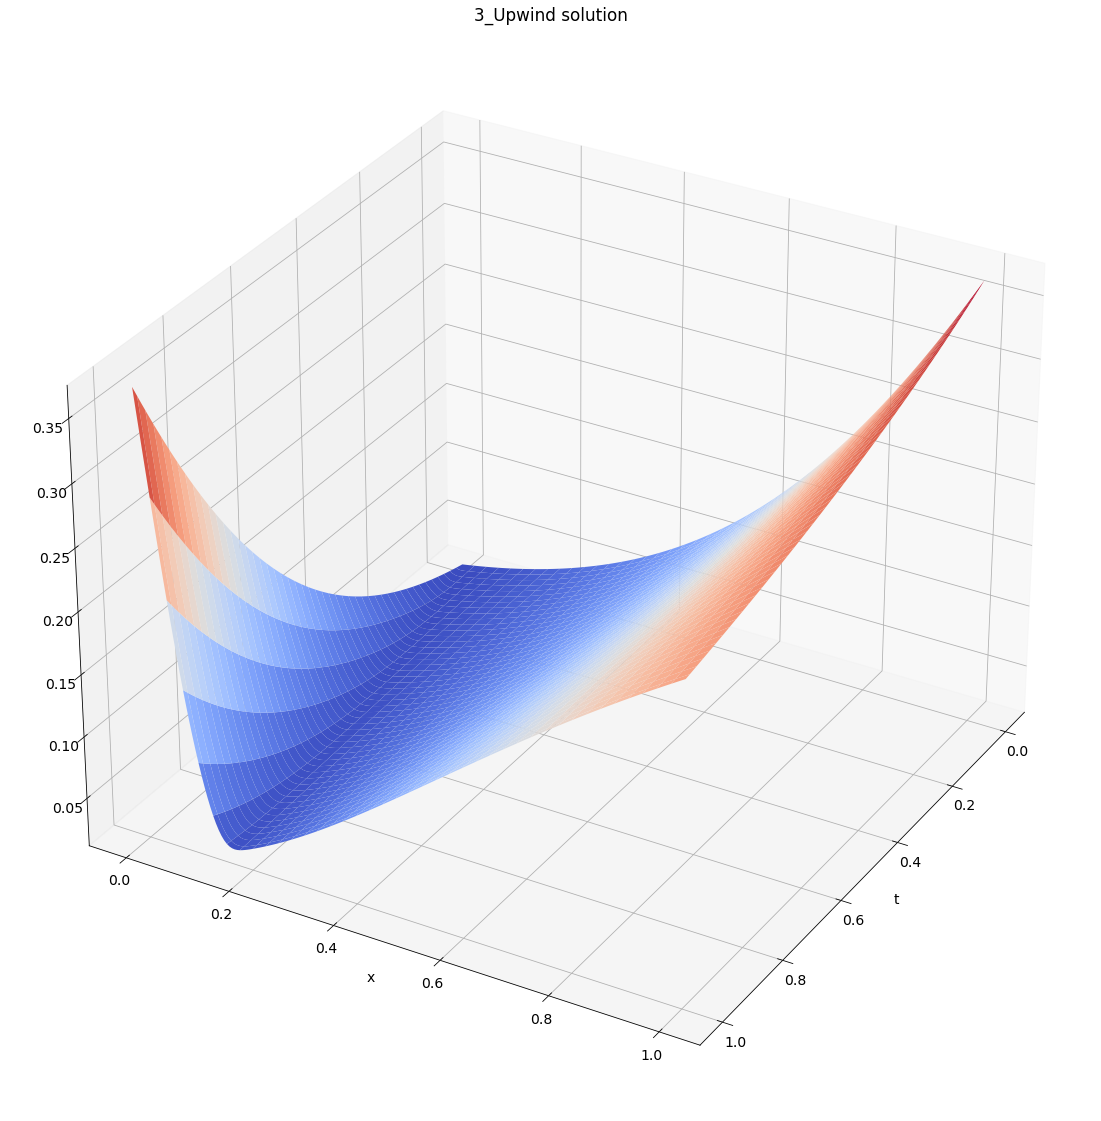

In [297]:
M = 100
N = 2000
U, x, t = UpwindScheme(f_gauss, g_exp, a_1)
plot_solution(x, t, U.T, txt = "3_Upwind solution", save = True)

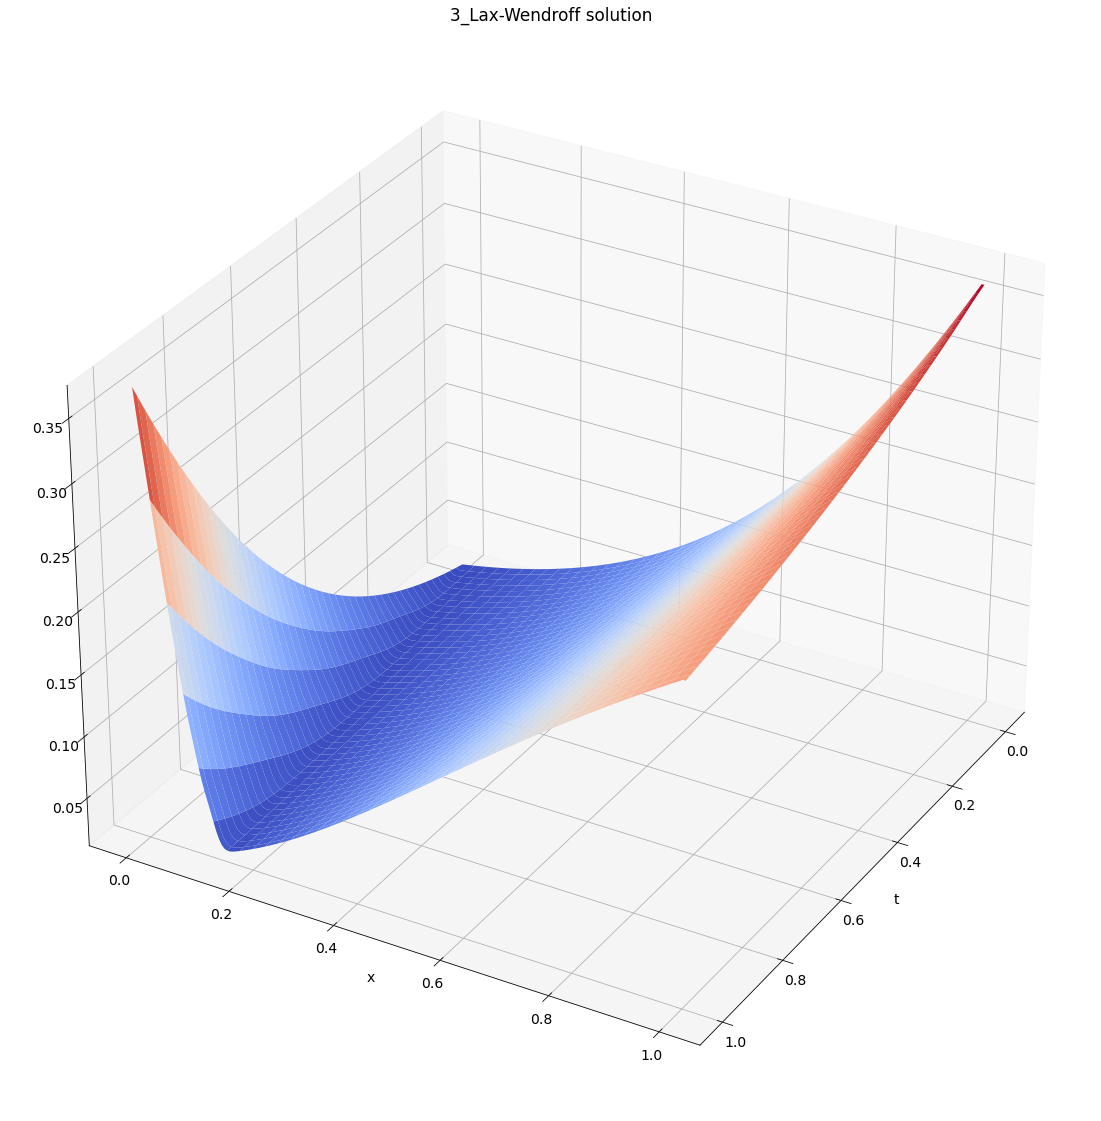

In [298]:
U, x, t = Lax_Wendroff(f_gauss, g_exp, a_1, a_1_x)
plot_solution(x, t, U.T,txt = "3_Lax-Wendroff solution", save = True)

### Convergence and error

In [299]:
def U_exact_1(t,x):
    return np.exp(-(x-1/2)**2)*np.sin(2*np.pi*t)
def U_exact_IC_1(x):
    return U_exact_1(0, x)
def U_exact_BC_1(t):
    return U_exact_1(t, 0)

def U_exact_2(t,x):
    return np.exp(-(x-1/2)**2)*np.sin(t)
def U_exact_IC_2(x):
    return U_exact_2(0, x)
def U_exact_BC_2(t):
    return U_exact_2(t, 0)

def U_exact_3(t,x):
    return np.sin(x)*np.exp(-t)
def U_exact_IC_3(x):
    return U_exact_3(0, x)
def U_exact_BC_3(t):
    return U_exact_3(t, 0)

In [300]:
u, x, t, a = smp.symbols("u x t a")
f = smp.exp(-(x - 1/2)**2)*smp.sin(t)
# f = smp.exp(-(t - 1/2)**2)*smp.sin(1+x)
# f = smp.sin(x)*smp.exp(-t)
a = (x - smp.Rational(1,3))*(x - smp.Rational(2,3))
RHS_sym = smp.diff(f, t) + a*smp.diff(f, x)
print(RHS_sym)
def U_exact_RHS_1(t, x):
    return (1.0 - 2*x)*(x - 2/3)*(x - 1/3)*np.exp(-(x - 0.5)**2)*np.sin(2*np.pi*t) + 2*np.pi*np.exp(-(x - 0.5)**2)*np.cos(2*np.pi*t)
def U_exact_RHS_2(t, x):
    return (1.0 - 2*x)*(x - 2/3)*(x - 1/3)*np.exp(-(x - 0.5)**2)*np.sin(t) + np.exp(-(x - 0.5)**2)*np.cos(t)
def U_exact_RHS_3(t, x):
    return (x - 2/3)*(x - 1/3)*np.exp(-t)*np.cos(x) - np.exp(-t)*np.sin(x)

(1.0 - 2*x)*(x - 2/3)*(x - 1/3)*exp(-(x - 0.5)**2)*sin(t) + exp(-(x - 0.5)**2)*cos(t)


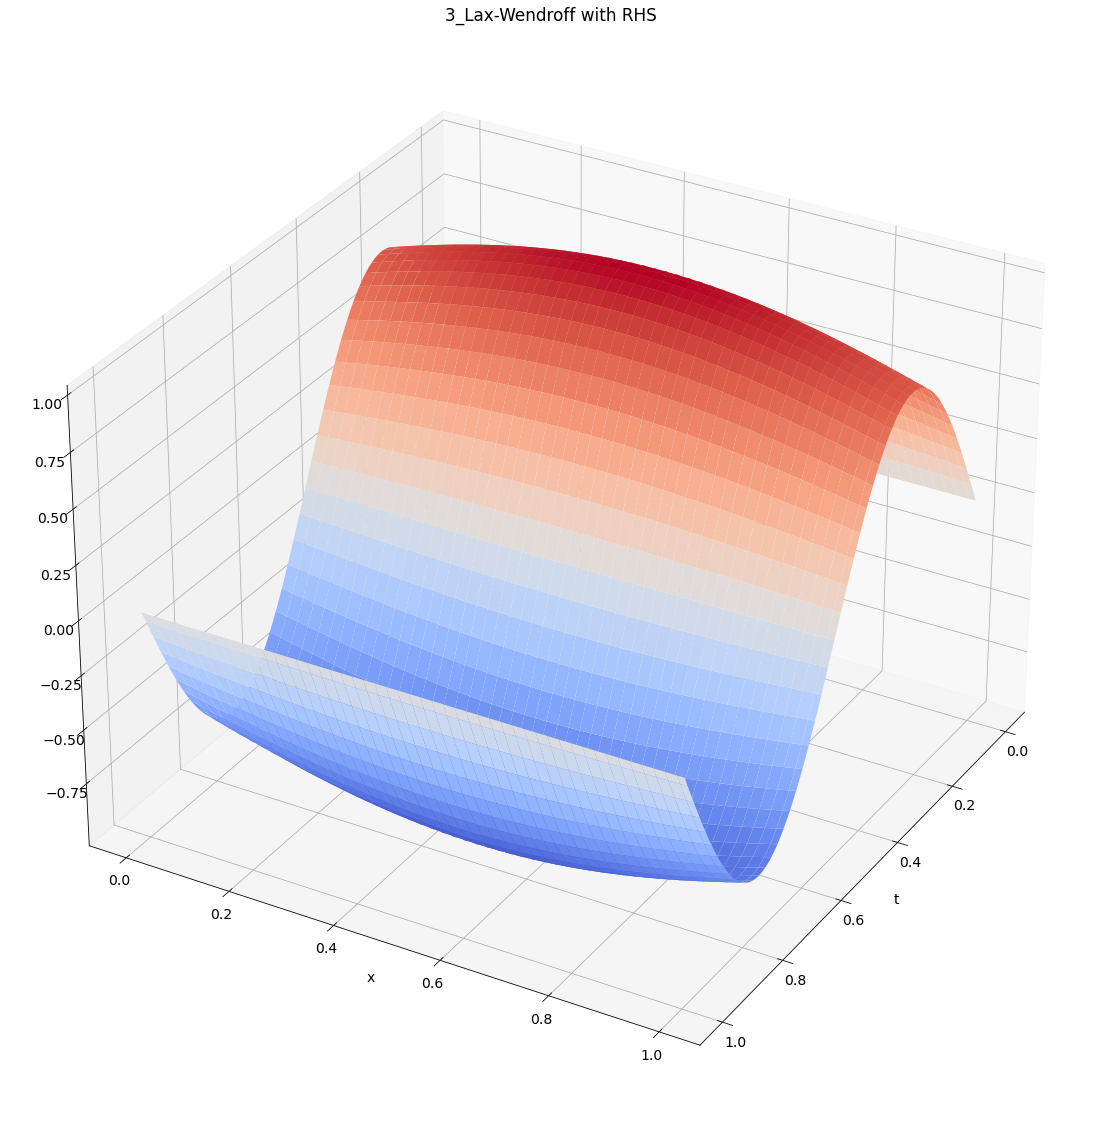

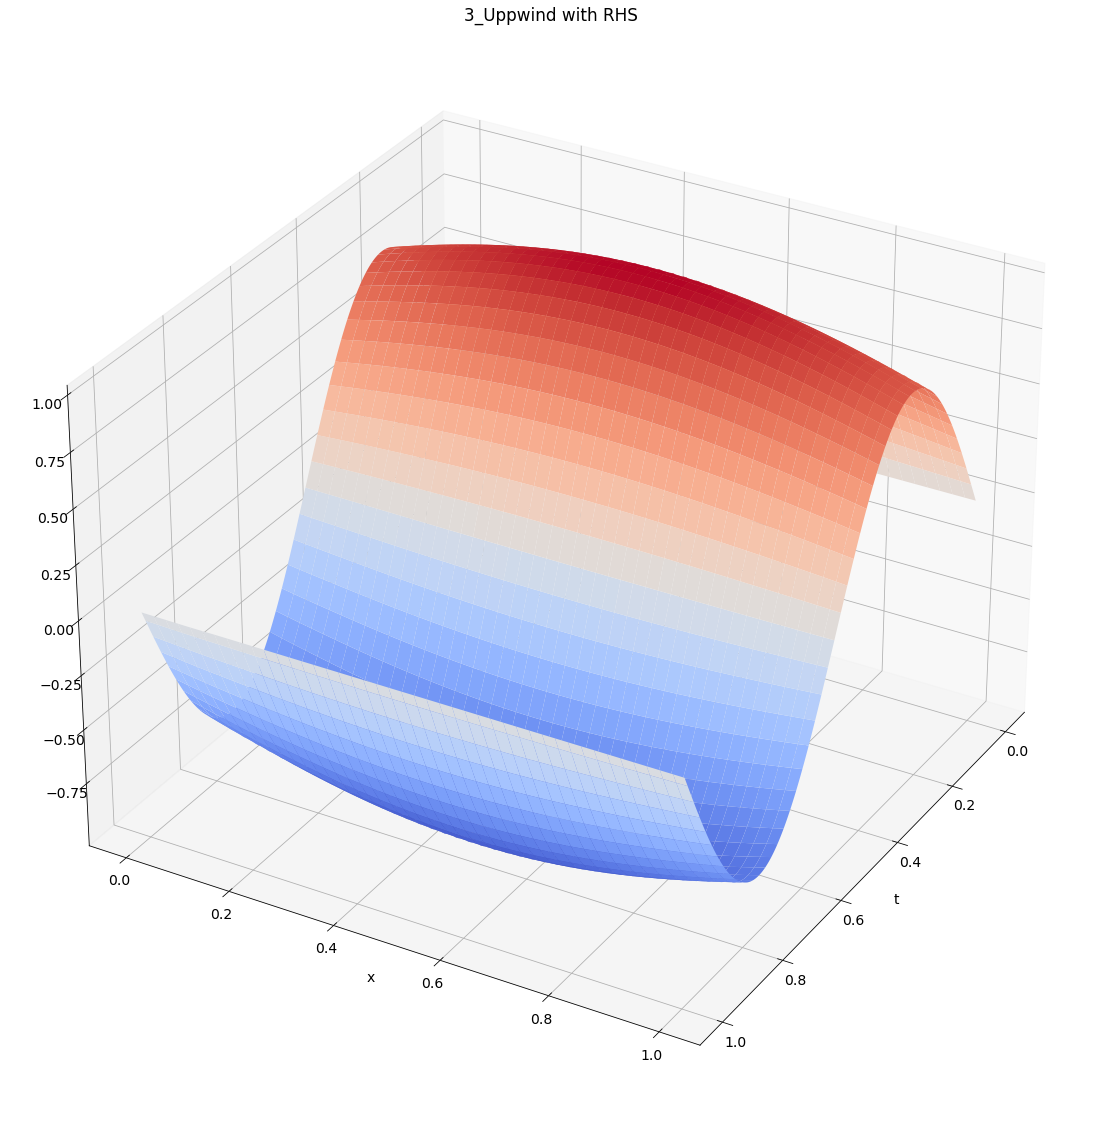

In [301]:
U_lax_RHS, x, t = Lax_Wendroff(U_exact_IC_1, U_exact_BC_1, a_1, a_1_x, M = 1000, N = 5000, RHS = U_exact_RHS_1)
plot_solution(x, t, U_lax_RHS.T, "3_Lax-Wendroff with RHS", save = True)
U_up_RHS, x, t = UpwindScheme(U_exact_IC_1, U_exact_BC_1, a_1, M = 300, N = 5000, RHS = U_exact_RHS_1)
plot_solution(x, t, U_up_RHS.T, "3_Uppwind with RHS", save = True)

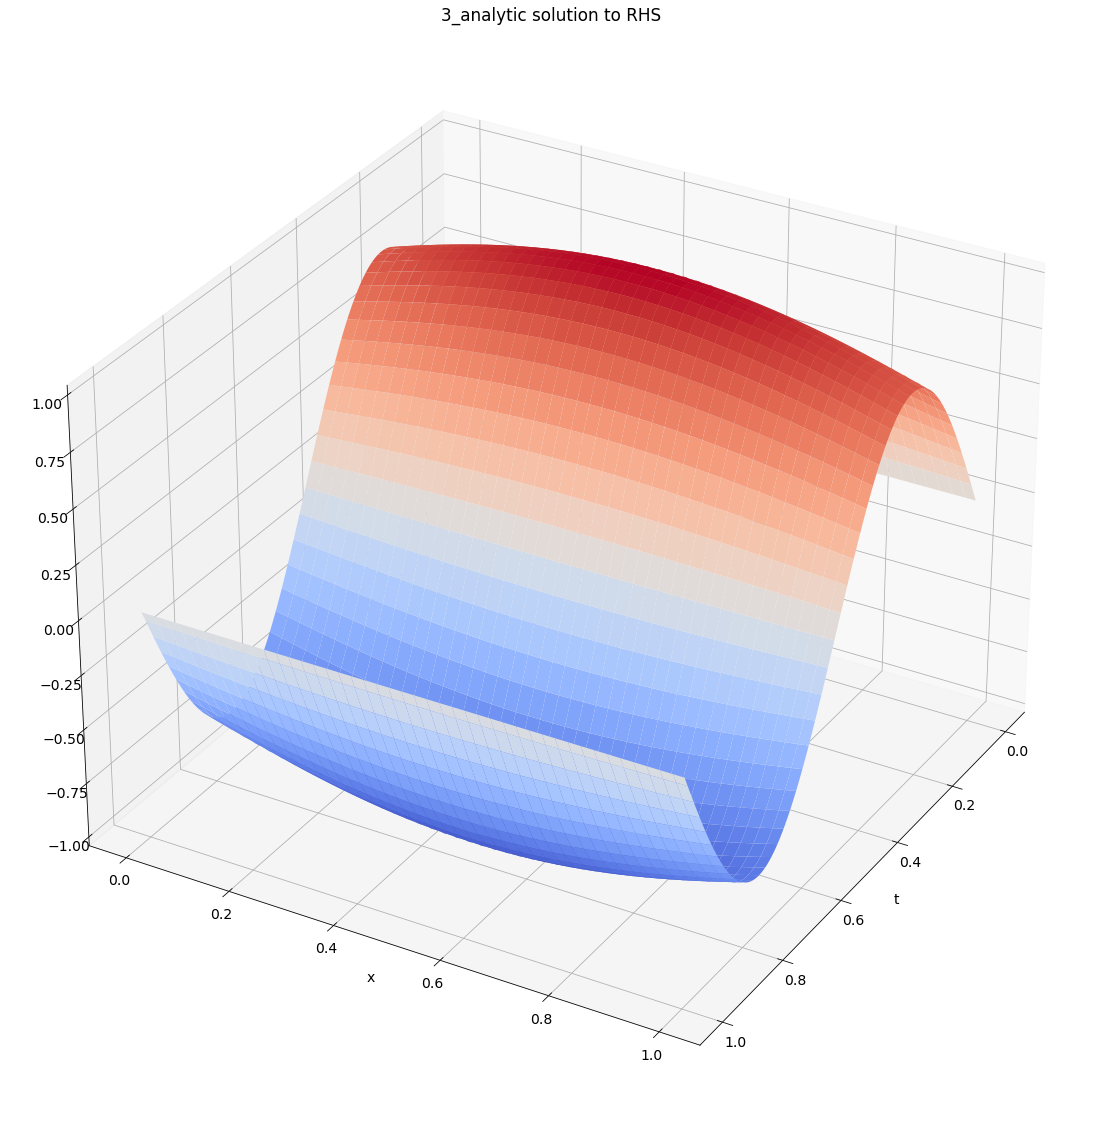

In [302]:
U_anal = np.zeros((len(t), len(x)))

for n, tn in enumerate(t):
    U_anal[n] = U_exact_1(tn, x)
plot_solution(x, t, U_anal.T, "3_analytic solution to RHS", save = True)

In [303]:
Ns = np.logspace(2.3, 3.5, 20, dtype = int)
Ns_float = np.logspace(2.3, 3.5, 20)
print(Ns)
error_list_up_N = np.zeros(len(Ns))
error_list_lax_N = np.zeros(len(Ns))
for count_N, N in enumerate(Ns):
    U_lax, x, t = Lax_Wendroff(U_exact_IC_1, U_exact_BC_1, a_1, a_1_x, M = int(Ns_float[0]*4), N = N, RHS = U_exact_RHS_1) #with a1 CFL requires M ish 5 times the value of M
    U_up, x, t = UpwindScheme(U_exact_IC_1, U_exact_BC_1, a_1, M = int(Ns_float[0]*4), N = N, RHS = U_exact_RHS_1)
    
    U_anal = np.zeros((len(t), len(x)))
    for n, tn in enumerate(t):
        U_anal[n] = U_exact_1(tn, x)
        
        
    error_list_up_N[count_N] = np.amax(U_up - U_anal)
    error_list_lax_N[count_N] = np.amax(U_lax - U_anal)

[ 199  230  266  308  356  412  477  552  638  738  854  987 1142 1321
 1528 1767 2044 2364 2734 3162]


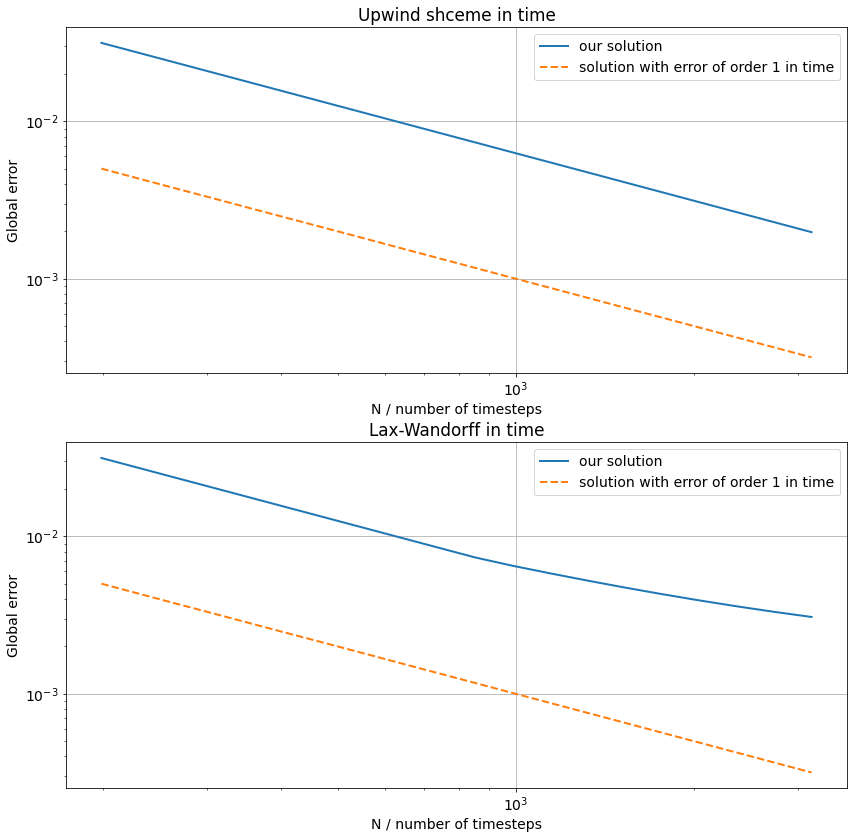

In [304]:
fig, ax = plt.subplots(2, figsize = (14,14))

ax[0].title.set_text("Upwind shceme in time")
ax[0].set_xlabel("N / number of timesteps")
ax[0].set_ylabel("Global error")
ax[0].loglog(Ns,error_list_up_N, label = "our solution")
ax[0].loglog(Ns,Ns_float**(-1),"--", label = "solution with error of order 1 in time")
ax[0].legend()

ax[1].title.set_text("Lax-Wandorff in time")
ax[1].set_xlabel("N / number of timesteps")
ax[1].set_ylabel("Global error")
ax[1].loglog(Ns,error_list_lax_N, label = "our solution")
ax[1].loglog(Ns,Ns_float**(-1),"--", label = "solution with error of order 1 in time")
ax[1].legend()

In [305]:
Ms = np.logspace(1, 2.5, 50, dtype = int)
Ms_float = np.logspace(1, 2.5, 50)
print(Ms)
error_list_up_M = np.zeros(len(Ms))
error_list_lax_M = np.zeros(len(Ms))
for count_M, M in enumerate(Ms):
    U_lax, x, t = Lax_Wendroff(U_exact_IC_1, U_exact_BC_1, a_1, a_1_x, N = 100000, M = M, RHS = U_exact_RHS_1) 
    U_up, x, t = UpwindScheme(U_exact_IC_1, U_exact_BC_1, a_1, N = 100000, M = M, RHS = U_exact_RHS_1)
    
    U_anal = np.zeros((len(t), len(x)))
    for n, tn in enumerate(t):
        U_anal[n] = U_exact_1(tn, x)
        
        
    error_list_up_M[count_M] = np.amax(U_up - U_anal) #L^inf norm of the ordered vektor containing all points in space and time
    error_list_lax_M[count_M] = np.amax(U_lax - U_anal)

[ 10  10  11  12  13  14  15  16  17  18  20  21  23  25  26  28  30  33
  35  38  40  43  47  50  54  58  62  67  71  77  82  88  95 102 109 117
 126 135 145 156 167 179 193 207 222 238 255 274 294 316]


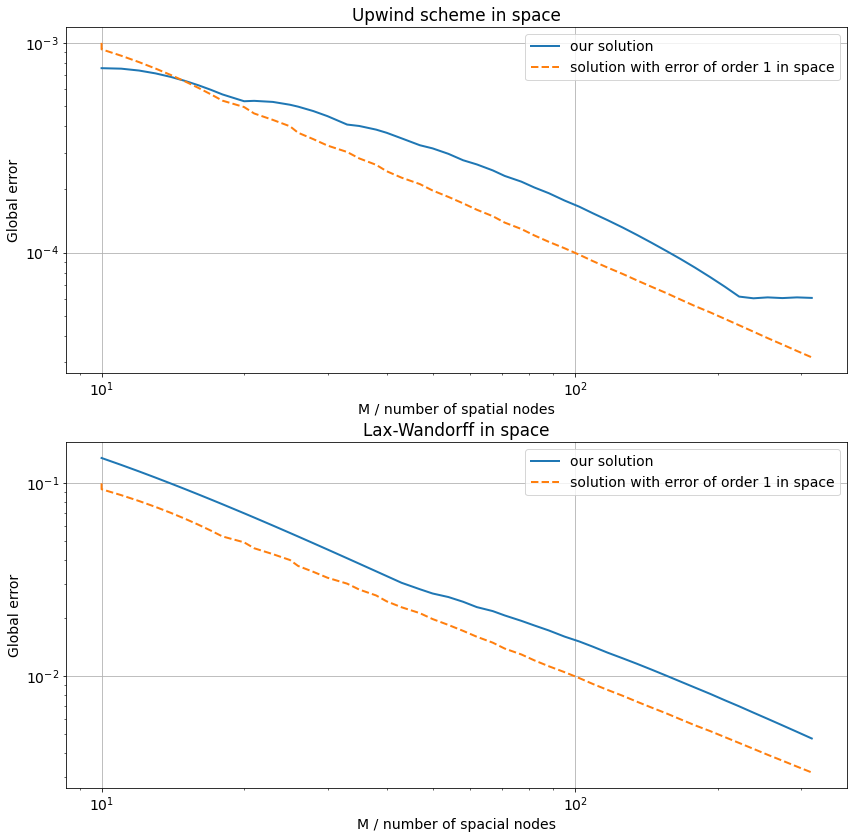

In [306]:
fig, ax = plt.subplots(2, figsize = (14,14))
ax[0].title.set_text("Upwind scheme in space")
ax[0].set_xlabel("M / number of spatial nodes")
ax[0].set_ylabel("Global error")
ax[0].loglog(Ms,error_list_up_M, label = "our solution")
ax[0].loglog(Ms,Ms_float**(-1)/100,"--", label = "solution with error of order 1 in space")#the facor before the ordimal here is just to align the starting points of the lines in the plot below
# ax[0].loglog(Ms,Ms_float**(-2)/100,"--", label = "solution with error of order 2 in space")
ax[0].legend()

ax[1].title.set_text("Lax-Wandorff in space")
ax[1].set_xlabel("M / number of spacial nodes")
ax[1].set_ylabel("Global error")
ax[1].loglog(Ms,error_list_lax_M, label = "our solution")
ax[1].loglog(Ms,Ms_float**(-1),"--", label = "solution with error of order 1 in space")
# ax[1].loglog(Ms,Ms_float**(-2),"--", label = "solution with error of order 2 in space")
ax[1].legend()